In [3]:
from collections import defaultdict
from fastai.vision.all import *

In [4]:
torch.cuda.set_device(0)

## Json 2 poly

In [5]:
def points2centroid(label_data):
    "Converts segmentation `label: String!` into polygons"
    centroids = []
    for xy_list in label_data:
        if 'geometry' in xy_list:  # V3
            p = xy_list['geometry']
            
            x,y = p['x'], p['y']
            centroids.append((x,y))
    return centroids

In [6]:
def json2centroid(label):
    return {k:points2centroid(v) for k,v in label.items()}

## Mask

In [8]:
Eosinophil      = (1, 0.6,   0, 1)  # orange
Lymphocyte      = (0,   1,   0, 1)  # green
MacroMono       = (1,   0,   0, 1)  # red 
Neutrophil      = (0,   1,   1, 1)  # cyan
Background      = (1,   1,   1, 0)  # cyan

TILE_SZ = 1024

class_map = {
    # LBName: (idx, display, color, radius)
    'Background': (0, 'Background', Background, None),
    'Eosinophil': (1, 'Eosinophil', Eosinophil, 50/TILE_SZ),
    'Lymphocyte': (2, 'Lymphocyte', Lymphocyte, 30/TILE_SZ),
    'Macrophage': (3, 'Macro+Mono', MacroMono,  100/TILE_SZ),
    'Monocyte':   (3, 'Macro+Mono', MacroMono,  100/TILE_SZ),
    'Neutrophil': (4, 'Neutrophil', Neutrophil, 50/TILE_SZ)
}

classes = sorted(set(class_map.values()))
classes

[(0, 'Background', (1, 1, 1, 0), None),
 (1, 'Eosinophil', (1, 0.6, 0, 1), 0.048828125),
 (2, 'Lymphocyte', (0, 1, 0, 1), 0.029296875),
 (3, 'Macro+Mono', (1, 0, 0, 1), 0.09765625),
 (4, 'Neutrophil', (0, 1, 1, 1), 0.048828125)]

In [9]:
# https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
def create_circular_mask(mask, center=None, radius=None):
    w,h = mask.shape
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [10]:
import numpy
from PIL import Image, ImageDraw

def centroid2mask(img, poly2lbl):
    w,h = img.shape
    img_msk = np.zeros((w,h))
    
    for k,v in poly2lbl.items():
        if k not in class_map: continue
        idx,label,color,radius = class_map[k]
        for pt in v:
            x,y = pt
#             msk = create_circular_mask(img_msk, (x,y), radius*w)
            msk = create_circular_mask(img_msk, (x,y), 14)
            img_msk[msk] = idx

    return img_msk

## Save Mask for all rows

In [10]:
def parse_row(row_data):
    label = row_data['Label']
    img_url = row_data['Labeled Data']
    img = img_from_url(img_url)
    poly2lbl = json2centroid(label)
    return img, poly2lbl

In [15]:
from fastprogress.fastprogress import progress_bar

In [16]:
out_path = Path('/data2/ashaw/WAMRI/DCNet/data/cytospin')

In [17]:
with open(out_path/'labels.json', 'r') as f:
    img2lbl = json.load(f)

In [19]:
def parse_pairs(row_data, sz=256, img_dir=out_path):
    label = row_data['label']
    img_path = out_path/row_data['image']
    if img_path.exists():
        img = PILImage.create(img_path)
    else:
        print('Could not locate image:', img_path)
    mask = centroid2mask(img, label)
    return img, mask

In [20]:
img2msk = []
from fastprogress.fastprogress import progress_bar

for row in progress_bar(img2lbl):  # generate masks for train/valid datasets
    img, mask = parse_pairs(row)
    img2msk.append((img, mask))
    
len(img2msk)

760

## Train U-Net

### Load Data into Fastai

In [23]:
from fastai.vision.all import *

In [25]:
def get_x(idx): return img2msk[idx][0]
def get_y(idx): return img2msk[idx][1]

idxs = range(len(img2msk))
tfms = [[get_x, PILImage.create, ToTensor, IntToFloatTensor], [get_y, PILMask.create, ToTensor]]
splits = RandomSplitter(seed=42)(idxs)
dsets = Datasets(items=idxs, tfms=tfms, splits=splits)
batch_tfms = [*aug_transforms(size=(256,256), flip_vert=True), Normalize.from_stats(*imagenet_stats)]
dls = dsets.dataloaders(bs=16, after_batch=batch_tfms)
dls.c = len(classes)

In [26]:
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

carray = [x[2] for x in classes]
cmap = mpl.colors.ListedColormap(carray)
colors = cmap(range(len(classes)))
cmap.set_under('k', 0.15)
patches = [mpatches.Patch(color=c, label=l[1]) for c,l in zip(colors,classes)]

show_args = { 'cmap': cmap, 'vmin': 0, 'vmax': len(classes), 'figsize': (20,20), 'alpha': 1.0 }

def show_legend(): plt.legend(handles=patches, bbox_to_anchor=(1, 1), loc='upper left')

## Metrics

In [27]:
xb,yb = dls.one_batch()

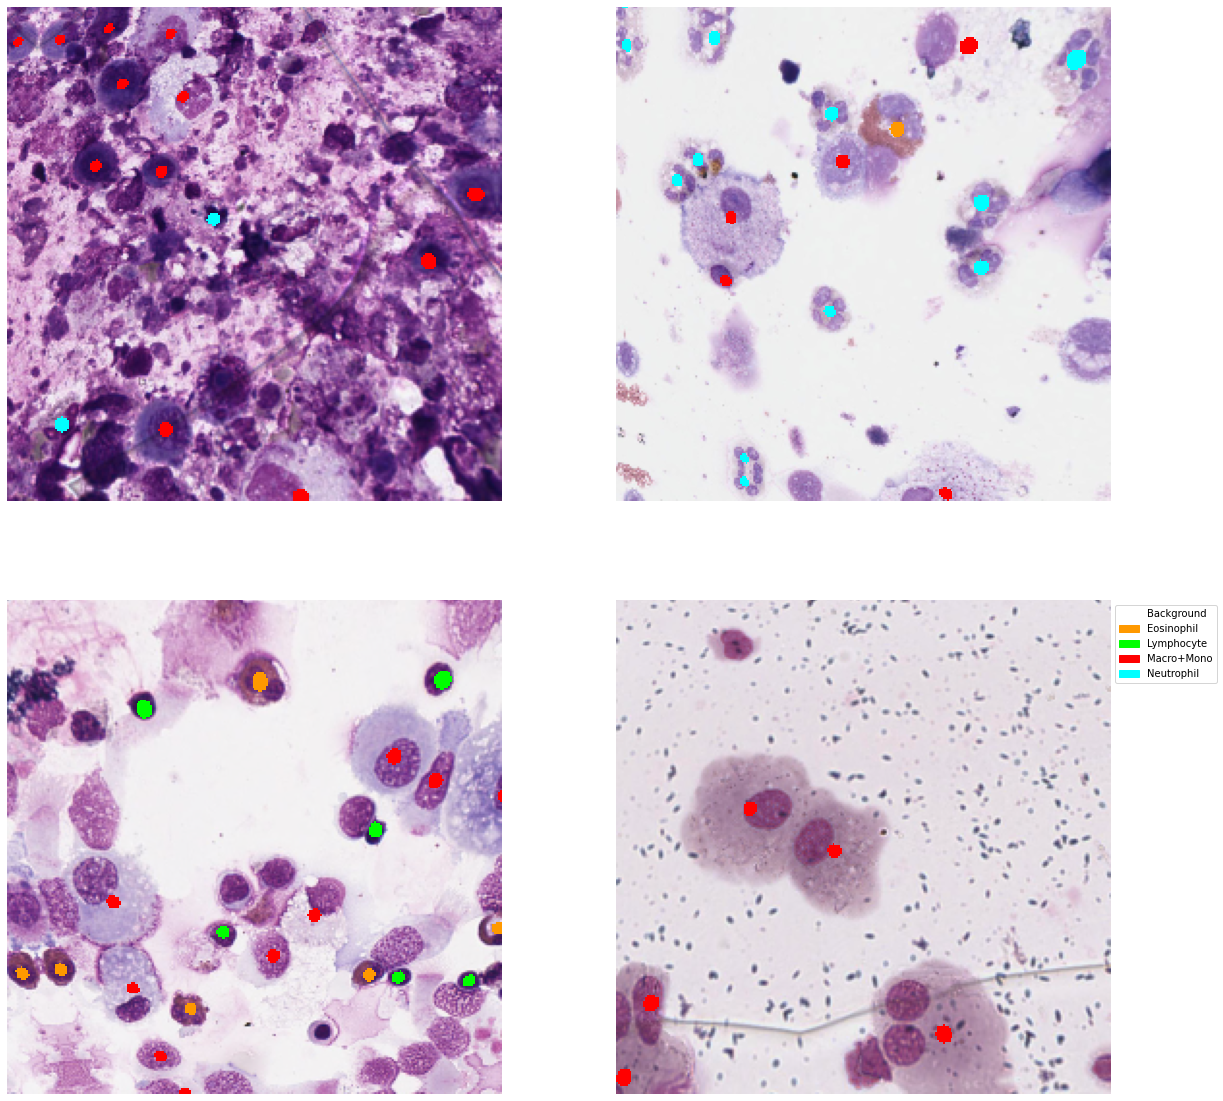

In [27]:
dls.show_batch(b=(xb,yb), max_n=4, **show_args)
show_legend()

## Train Model

In [29]:
void_code = 0

def acc_nuclei(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [30]:
# implementation here - https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/8

class FocalLoss(nn.Module):
    
    def __init__(self, weight=None, 
                 gamma=2., reduction='none', axis=1):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction
        self.axis=axis
        
    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=self.axis)
        prob = torch.exp(log_prob)
        loss =  F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob, 
            target_tensor, 
            weight=self.weight,
            reduction = self.reduction
        )
        return loss.mean()

    def decodes(self, x):    
        return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [31]:
ratio = {'Background': 100, 'Eosinophil': 6, 'Macro+Mono': 30, 'Neutrophil': 30, 'Lymphocyte': 7}
ratio

{'Background': 100,
 'Eosinophil': 6,
 'Macro+Mono': 30,
 'Neutrophil': 30,
 'Lymphocyte': 7}

In [32]:
tot = sum(ratio.values())
weight = torch.tensor([tot/ratio[c[1]] for c in classes]); weight

tensor([ 1.7300, 28.8333, 24.7143,  5.7667,  5.7667])

In [33]:
loss_func = FocalLoss(weight=weight.float().cuda())
learn = unet_learner(dls, resnet34, metrics=acc_nuclei, loss_func=loss_func, pretrained=True).to_fp16()
learn.path = out_path

In [34]:
learn.fit(4, 2e-4, wd=1e-5)

epoch,train_loss,valid_loss,acc_nuclei,time
0,2.431170,0.319060,0.000000,00:12
1,1.115302,0.181940,0.010269,00:08
2,0.671364,0.128065,0.036574,00:08
3,0.448928,0.107959,0.058306,00:08


In [35]:
learn.unfreeze()
learn.fit_one_cycle(60, slice(2e-3), wd=1e-5)
learn.save('centernet-segmentation')

epoch,train_loss,valid_loss,acc_nuclei,time
0,0.139350,0.126001,0.033390,00:09
1,0.124089,0.102930,0.103979,00:09
2,0.110833,0.084630,0.162637,00:09
3,0.098483,0.075284,0.221307,00:09
4,0.087658,0.070209,0.307013,00:10
5,0.078360,0.059026,0.241327,00:09
6,0.073080,0.064651,0.249016,00:09
7,0.071565,0.081376,0.467799,00:09
8,0.070827,0.057646,0.338693,00:09
9,0.066157,0.058325,0.360959,00:09


Path('models/centernet-segmentation-fix.pth')

## Load

## Metrics

In [34]:
import cv2
from functools import partial
from scipy import stats

In [35]:
learn.load('centernet-segmentation')

In [36]:
preds, lbls = learn.get_preds()
preds = preds.detach().cpu().numpy()
lbls = lbls.detach().cpu().numpy()

In [37]:
def compute_ap(precision, recall):
    "Compute the average precision for `precision` and `recall` curve."
    recall = np.concatenate(([0.], list(recall), [1.]))
    precision = np.concatenate(([0.], list(precision), [0.]))
    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = np.maximum(precision[i - 1], precision[i])
    idx = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[idx + 1] - recall[idx]) * precision[idx + 1])
    return ap

def max_px(box, targ):
    m = np.zeros_like(targ)
    y,x,h,w = box
    m[:, x:x+w,y:y+h] = 1
    m[0] = 0
    ind = np.unravel_index(np.argmax(targ*m, axis=None), targ.shape)
    return ind

def euclidean_dist(pt1, pt2):
    (xA,yA), (xB,yB) = pt1, pt2
    return ((xB-xA)**2 + (yB-yA)**2)**0.5

In [38]:
def midpt(box):
    x,y,w,h = box
    return (y+h//2), (x+w//2)

In [39]:
def extract_predictions(lbl, pred, score_thresh=0.1):
    contours,hierarchy = cv2.findContours(pred.argmax(0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    pboxes = [cv2.boundingRect(cnt) for cnt in contours if cv2.contourArea(cnt) >= min_area]
    pred_points = [max_px(pbox, pred) for pbox in pboxes]
    
    contours,hierarchy = cv2.findContours(lbl.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    lbl_points = [midpt(cv2.boundingRect(cnt)) for cnt in contours]
    lbl_points = [(lbl[x,y],x,y) for x,y in lbl_points]
    
    return pred_points, lbl_points

In [40]:
def calc_class_ap(lbls, preds, min_area=4, iou_thresh=0.1, score_thresh=0.3):
    metrics = {}
    for idx,lbl,color,radius in classes:
        if idx == 0: continue
        metrics[lbl] = [],[],[],[]
        
    for lbl,pred in zip(lbls,preds): # iterate through labels and predictions
        pred_points, lbl_points = extract_predictions(lbl, pred, score_thresh)
        
        for idx,cls,color,radius in classes: # calculate ap per class
            if idx == 0: continue
            tps, fps, scores, n_gts = metrics[cls]
            
            ppoints = [pp for pp in pred_points if pp[0] == idx]
            ppoints = list(sorted(ppoints, key=lambda x: pred[x], reverse=True)) # sort by scores
#             print(list(sorted([pred[x] for x in ppoints], reverse=True)))
            lpoints = [lb for lb in lbl_points if lb[0] == idx]
            pdists = []
            pscores = []
            matched = set()
            for ppoint in ppoints:
                all_dists = [(euclidean_dist(lpoint[1:], ppoint[1:]), lpoint) for lpoint in lpoints if lpoint not in matched]
                if len(all_dists) == 0:
                    pdists.append(1e10)
                else:
                    pdist, lpoint = min(all_dists)
                    matched.add(lpoint) # Found match. Remove label so it can't be matched again
                    pdists.append(pdist)
                pscores.append(pred[ppoint])
                
            w,h = lbl.shape[-2:]
            max_dist = radius * w * iou_thresh
            
            tp = (np.array(pdists) < max_dist)
            fp = ~tp

            n_gts.append(len(lpoints))
            tps.extend(tp.astype(np.uint8).tolist())
            fps.extend(fp.astype(np.uint8).tolist())
            scores.extend(pscores)
        
    aps = []
    for idx,cls,color,radius in classes:
        if idx == 0: continue
        tps, fps, scores, n_gts = metrics[cls]
        res = sorted(zip(scores, tps, fps), key=lambda x: x[0], reverse=True)
        res = np.array(res)
        if len(res) == 0: res = np.zeros((1, 3))
        tp = res[:,1].cumsum(0)
        fp = res[:,2].cumsum(0)
        precision = tp / (tp + fp + 1e-8)
        recall = tp / (sum(n_gts) + 1e-8)
        
        aps.append({ 
            'class': cls, 
            'ap': round(compute_ap(precision, recall), 4), 
            'tp': int(tp[-1]), 
            'fp': int(fp[-1]), 
            'gt': sum(n_gts)
        })
        
    aps.append({
        'class': 'all',
        'ap': np.mean([x['ap'] for x in aps]),
        'tp': sum([x['tp'] for x in aps]),
        'fp': sum([x['fp'] for x in aps]),
        'gt': sum([x['gt'] for x in aps]),
    })
    return aps

In [41]:
thresh = []
for iou_thresh in [0.1, 0.25, 0.5]:
    aps = []
    for score_thresh in [0.5]:
        for min_area in [2,3]:
            ccap = calc_class_ap(lbls,preds, score_thresh=score_thresh, min_area=min_area, iou_thresh=iou_thresh)
            aps.append((ccap[-1]['ap'], score_thresh, min_area))
    print(iou_thresh, max(aps))
    thresh.append((iou_thresh,) + max(aps)[1:])

0.1 (0.1395, 0.5, 3)
0.25 (0.592975, 0.5, 2)
0.5 (0.7678, 0.5, 2)


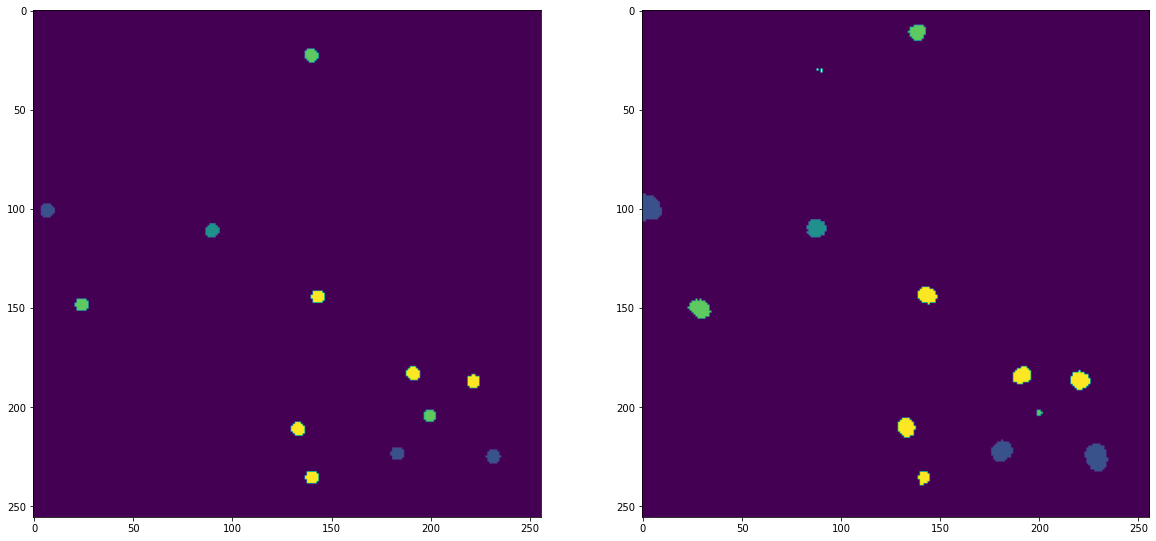

In [52]:
fix, ax = plt.subplots(nrows=1,ncols=2,figsize=(20,20))
ax[0].imshow(lbls[0])
ax[1].imshow(preds[0].argmax(0))

In [53]:
preds.shape

(72, 5, 256, 256)

In [54]:
lbls.shape

(72, 256, 256)

In [55]:
for iou_thresh, score_thresh, min_area in thresh:
    df = pd.DataFrame(calc_class_ap(lbls,preds, score_thresh=score_thresh, min_area=min_area, iou_thresh=iou_thresh))
    print(f'iou_thresh', iou_thresh, f'score_thresh', score_thresh, f'min_area', min_area, 'all', df.iloc[-1]['ap'])
    print(df)
    print("")

iou_thresh 0.1 score_thresh 0.5 min_area 3 all 0.125075
        class        ap   tp   fp    gt
0  Eosinophil  0.091900   24  103    98
1  Lymphocyte  0.008900    5  159    79
2  Macro+Mono  0.309900  246  369   547
3  Neutrophil  0.089600   86  304   355
4         all  0.125075  361  935  1079

iou_thresh 0.25 score_thresh 0.5 min_area 3 all 0.5327
        class      ap   tp   fp    gt
0  Eosinophil  0.5331   63   64    98
1  Lymphocyte  0.3399   38  126    79
2  Macro+Mono  0.6689  397  218   547
3  Neutrophil  0.5889  235  155   355
4         all  0.5327  733  563  1079

iou_thresh 0.5 score_thresh 0.5 min_area 2 all 0.7253000000000001
        class      ap   tp   fp    gt
0  Eosinophil  0.7957   81   48    98
1  Lymphocyte  0.6075   57  109    79
2  Macro+Mono  0.7330  428  194   547
3  Neutrophil  0.7650  281  114   355
4         all  0.7253  847  465  1079

